In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go

# 整理資料

In [2]:
data = pd.read_table('TXF_1 min.txt', sep=',')

data = data[['<Date>', ' <Time>',
             ' <Open>', ' <High>', ' <Low>', ' <Close>', ' <TotalVolume>']]

data.columns = ['date', 'time',
                'open', 'high', 'low', 'close', 'volume']

def transform_datetime(x):
    temp_time = x['date'] + '/' + x['time'].split('.')[0]
    return datetime.strptime(temp_time, '%m/%d/%Y/%H:%M:%S')

data['date_time'] = list(
    map(lambda x:datetime.strptime(x, '%m/%d/%Y/%H:%M:%S'),
        data.date.values + '/' + list(map(lambda x: x[:-4], data.time.values)))
)
data.date = data.date.apply(lambda x: datetime.strptime(x, '%m/%d/%Y'))
data.head()

,date,time,open,high,low,close,volume,date_time
0,2007-01-02,08:46:00.000,7880,7900,7880,7891,376,2007-01-02 08:46:00
1,2007-01-02,08:47:00.000,7889,7893,7884,7889,170,2007-01-02 08:47:00
2,2007-01-02,08:48:00.000,7891,7898,7889,7898,138,2007-01-02 08:48:00
3,2007-01-02,08:49:00.000,7895,7899,7895,7898,138,2007-01-02 08:49:00
4,2007-01-02,08:50:00.000,7898,7899,7892,7894,135,2007-01-02 08:50:00


# 日盤-建立高低點與開盤收盤

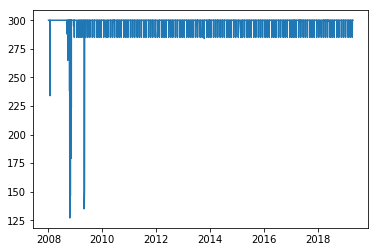

In [3]:
# 選取日盤資料
target_data = data[data.date_time.apply(lambda x: (x.hour >= 8) and (x.hour <= 13))]
target_data = target_data[target_data.date.apply(lambda x: x.year) > 2007]

# 有掉資料的狀況
plt.plot(target_data.groupby('date').count()['time'])

In [4]:
# 建立高低點資料
def select_highest(x):
    return x.max()

def select_lowest(x):
    return x.min()

aggregation = {
    'high': lambda x: select_highest(x),
    'low': lambda x: select_lowest(x)
}

high_and_low = target_data.groupby('date').agg(aggregation)

high_and_low['difference'] = high_and_low['high'] - high_and_low['low']

# 建立開盤收盤資料
def select_open(x):
    return x.iloc[0]

def select_close(x):
    return x.iloc[-1]

aggregation = {
    'open': lambda x: select_open(x),
    'close': lambda x: select_close(x)
}

open_and_close = target_data.groupby('date').agg(aggregation)
open_and_close['difference'] = abs(open_and_close['open'] - open_and_close['close'])

# 繪圖

In [5]:
# 先建立x index
# 邏輯是x=[2008, 2008, 2009, ...]，y=[2008對應到的值, 2008對應到的值, 2009對應到的值...]
date_index = pd.DataFrame(high_and_low.index)
date_index['year'] = date_index.date.apply(lambda x: x.year)
y_number_per_year = date_index.groupby('year').count()['date'].values
years = date_index.year.unique()

x_index = []
for i in range(len(years)):
    temp = [years[i]]*y_number_per_year[i]
    x_index.extend(temp)

In [6]:
trace_1 = go.Box(
    x=x_index,
    y=high_and_low['difference'],
    name='High minus Low',
    boxmean=True
)

trace_2 = go.Box(
    x=x_index,
    y=open_and_close['difference'],
    name='Distance betweeen Open and Close',
    boxmean=True
)

layout = go.Layout(
    # 有些吃go物件有些直接指定
    title='TXF: High minus Low vs Distance betweeen Open and Close <br> (standard trading hours)',
    
    titlefont=go.layout.Titlefont(
        size=20,
        color='grey'
    ),
    
    xaxis=go.layout.XAxis(
        showgrid=False,
        zeroline=False,
        showticklabels=True
    ),
    
    yaxis=go.layout.YAxis(
        zeroline=False,
        gridcolor='white'
    ),
    
    boxmode='group',
    
    legend=go.layout.Legend(
        x=0.01,
        y=0.95,
        font={'size': 15}
    ),
    
    paper_bgcolor='rgb(255,255,255)',
    
    plot_bgcolor='rgb(255,255,255)'

)

# 另一種沒有用go物件的寫法
# layout = {
#     'xaxis': {'showgrid':False,'zeroline':False,'showticklabels':True},
#     'yaxis': {'zeroline':False,'gridcolor':'white'},
#     'paper_bgcolor': 'rgb(243,243,243)',
#     'plot_bgcolor': 'rgb(243,243,243)',
#     'boxmode': 'group',
#     'legend': dict(x=0.01, y=0.95, font={'size': 15}),
#     'title': 'TXF: High minus Low vs Distance betweeen open and close'
# }

data_plotly = [trace_1, trace_2]

fig = go.Figure(data_plotly, layout=layout)
py.iplot(fig, filename='TXF K bar distrubition')

result is avaliable at:

https://plot.ly/~andy566159/22.embed

# Note

### 找尋高低點時發現用groupby.agg()的速度快很多

In [7]:
%%time

def select_highest(x):
    return x.max()

def select_lowest(x):
    return x.min()

aggregation = {
    'high': lambda x: select_highest(x),
    'low': lambda x: select_lowest(x)
}

high_and_low = target_data.groupby('date').agg(aggregation)

Wall time: 1.1 s


In [8]:
%%time

high_and_low_2 = pd.concat([
    target_data.groupby('date').max()[['high']],
    target_data.groupby('date').min()[['low']]
], axis=1)

Wall time: 6.09 s


### 繪圖有很多種方法，以下為別種方式(主要差異為是否用到go物件)

In [9]:
open_and_close['year'] = list(map(lambda x: x.year, open_and_close.index))
N = len(years)

c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]

plotly_data = [{
    'name': str(years[i]),
    'y': open_and_close[open_and_close.year == years[i]].difference.values,
    'type': 'box',
    'boxmean': True,
    'marker': {'color': c[i]}
} for i in range(len(years))]

layout = {'xaxis': {'showgrid':False,'zeroline':False, 'tickangle':60,'showticklabels':False},
          'yaxis': {'zeroline':False,'gridcolor':'white'},
          'paper_bgcolor': 'rgb(243,243,243)',
          'plot_bgcolor': 'rgb(243,243,243)',
          }

fig = go.Figure(plotly_data, layout=layout)
py.iplot(fig, filename='TXF K bar - Distance betweeen Open and Close')

result is avaliable at:

https://plot.ly/~andy566159/26.embed

### 日盤、夜盤英文

* 日盤: Standard trading hours
* 夜盤: After-hours trading

# Reference
* Python string to datetime – strptime()

  https://www.journaldev.com/23365/python-string-to-datetime-strptime
  
* plotly boxplot

  https://plot.ly/python/box-plots/#styling-outliers
 
* Summarising, Aggregating, and Grouping data in Python Pandas

  https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/